In [1]:
import torch 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchtext
from torchtext.data import Field, LabelField, BucketIterator 

from torchtext.datasets import IMDB

import spacy 
import numpy as np
import math
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os

# torch.backends.cudnn.deterministic = True

In [2]:
# gpu_devices = ','.join([str(id) for id in range(torch.cuda.device_count())])
# os.environ["CUDA_VISIBLE_DEVICES"] = gpu_devices

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)
print(device)
print(torch.cuda.current_device())

cuda
1


In [5]:
spacy_en = spacy.load("en_core_web_sm")

In [6]:
def tokenizer_en(text):
    return [token.text for token in spacy_en.tokenizer(text.lower())]

In [7]:
TEXT = Field(
    lower="True",
    tokenize=tokenizer_en,
    sequential=True,
#     fix_length=500,
    include_lengths=True
)

LABEL = LabelField(dtype=torch.float)

In [8]:
import random

In [9]:
train_data, test_data = IMDB.splits(
    TEXT, LABEL
)
# train_data, validation_data = train_data.split(random_state=random.seed(1))

print("Total train data is {}".format(len(train_data)))
# print("Total validation data is {}".format(len(validation_data)))
print("Total test data is {}".format(len(test_data)))

Total train data is 25000
Total test data is 25000


In [10]:
TEXT.build_vocab(train_data, min_freq=5, vectors="glove.6B.100d")
LABEL.build_vocab(train_data,)
len(TEXT.vocab), len(LABEL.vocab)

(31289, 2)

In [11]:
print(vars(train_data.examples[0]))

{'text': ['zentropa', 'has', 'much', 'in', 'common', 'with', 'the', 'third', 'man', ',', 'another', 'noir', '-', 'like', 'film', 'set', 'among', 'the', 'rubble', 'of', 'postwar', 'europe', '.', 'like', 'ttm', ',', 'there', 'is', 'much', 'inventive', 'camera', 'work', '.', 'there', 'is', 'an', 'innocent', 'american', 'who', 'gets', 'emotionally', 'involved', 'with', 'a', 'woman', 'he', 'does', "n't", 'really', 'understand', ',', 'and', 'whose', 'naivety', 'is', 'all', 'the', 'more', 'striking', 'in', 'contrast', 'with', 'the', 'natives.<br', '/><br', '/>but', 'i', "'d", 'have', 'to', 'say', 'that', 'the', 'third', 'man', 'has', 'a', 'more', 'well', '-', 'crafted', 'storyline', '.', 'zentropa', 'is', 'a', 'bit', 'disjointed', 'in', 'this', 'respect', '.', 'perhaps', 'this', 'is', 'intentional', ':', 'it', 'is', 'presented', 'as', 'a', 'dream', '/', 'nightmare', ',', 'and', 'making', 'it', 'too', 'coherent', 'would', 'spoil', 'the', 'effect', '.', '<', 'br', '/><br', '/>this', 'movie', 'i

In [12]:
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    device=device,
    batch_sizes=(32, 32),
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
#     num_workers=4
    
)
print(len(train_iterator), len(test_iterator))

782 782


In [13]:
for batch in train_iterator:
    break

In [14]:
batch.text[0], batch.text[1].shape, batch.label.shape

(tensor([[  300,    65,   263,  ...,    57,    12, 16958],
         [   82,    12,   181,  ...,  6387,   158,    17],
         [ 1108,   101,  2384,  ...,    16,    92,     0],
         ...,
         [  565, 21070,    11,  ...,   146,    30,   122],
         [ 1256,   334,     0,  ...,   146,     4,     4],
         [    4,  3914,     4,  ...,     1,     1,     1]], device='cuda:1'),
 torch.Size([32]),
 torch.Size([32]))

Bidirectional Unit

In [15]:
class DeepMoji(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_state_size, num_layers,
                 output_dim, pad_idx, dropout=0.5, bidirectional=True):

        super(DeepMoji, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_state_size = hidden_state_size
        self.num_layers=num_layers
        self.output_dim = output_dim
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.pad_idx = pad_idx
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        self.bilstm_one = nn.LSTM(
            input_size=self.embedding_dim, hidden_size=self.hidden_state_size,
            bidirectional=self.bidirectional
        )
        
        # do somethingg about layer two input
        
        self.bilstm_two = nn.LSTM(
            input_size=2 * self.hidden_state_size, hidden_size=self.hidden_state_size,
            bidirectional=self.bidirectional
        )
        
        self.attn_layer = AttentionLayer(self.hidden_state_size, self.num_layers, self.embedding_dim)

        self.output_layer = nn.Linear(self.hidden_state_size * 2 * self.num_layers, self.output_dim)
        
        self.dropout_layer = nn.Dropout(self.dropout)
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        # [batch_size, src_sent_len]
        return mask
    
    def forward(self, inp, src_len):
        
        # inp = [sent_length, batch_size]
        # src_len = [batch_size]
        
        embedded = self.dropout_layer(self.embedding(inp))
        # embedded = [sent_length, batch_size, embedding_dim]
        
        embedded_packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        
        bilstm_out_1_packed, (_, _) = self.bilstm_one(embedded_packed)
        # bilstm_out_1 = [seq_len, batch_size, 2 * hidden_state_size] 
        
        bilstm_out_2_packed, (_, _) = self.bilstm_two(bilstm_out_1_packed) 
        # bilstm_out_1 = [seq_len, batch_size, 2 * hidden_state_size]
        
        bilstm_out_1, _ = nn.utils.rnn.pad_packed_sequence(bilstm_out_1_packed)
        bilstm_out_2, _ = nn.utils.rnn.pad_packed_sequence(bilstm_out_2_packed)
                
        bilstm_stacked = torch.cat((bilstm_out_1, bilstm_out_2), dim=2)
        # bilstm_stacked = [seq_len, batch_size, 4 * hidden_state_size]
                
        mask = self.create_mask(inp)
        
        attn_weights = self.attn_layer(embedded, bilstm_stacked, mask).unsqueeze(1)
        # attn_weights = [batch_size, 1, seq_len]
        
        attended_hidden_representation = torch.bmm(attn_weights, bilstm_stacked.permute(1, 0, 2)).squeeze(1)
        # attended_hidden_representation = [batch_size, 4 * hidden_state]
        
        # print("attended shape == {}".format(attended_hidden_representation.shape))

        outputs = self.output_layer(attended_hidden_representation)
        # outputs = [batch_size, output_dim]
        # print("Output shape == {}".format(outputs.shape))

        return outputs

Attention Layer

In [16]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_state_size, num_layers, embedding_dim):
        super(AttentionLayer, self).__init__()
        self.hidden_state_size = hidden_state_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        
#         self.attn = nn.Linear((self.num_layers * 2 * self.hidden_state_size) + self.embedding_dim, self.hidden_state_size)
        
        self.attn = nn.Parameter(torch.rand((self.num_layers * 2 * self.hidden_state_size) + self.embedding_dim))
        
        
    def forward(self, embedded, lstm_outputs, mask):
        # embedded = [src_sent_len, batch_size, embedding_dim]
        # lstm_outputs = [src_sent_len, batch_size, enc_hidden_state_size*2*2]
        
        batch_size = embedded.shape[1]
        # calculating energies
        
        embed_concat = torch.cat((embedded, lstm_outputs), dim=2)
        # embed_concat = [src_sent_len, batch_size, embedding_dim + hidden_state_size*4]
        
        attn = self.attn.repeat(batch_size, 1).unsqueeze(2)
        # attn = [batch_size, 4*hidden_state + embedding_dim, 1]
        
        attention = torch.bmm(embed_concat.permute(1,0,2), attn).squeeze(2)
        # attention = [batch_size, seq_len]
        
        attn_weights = attention.masked_fill(mask == 0, -1e10)
        # attn_weights = [batch_size, seq_len]
        
        attn_weights = F.softmax(attention, dim=1)
        # attn_weights = [batch_size, seq_len]
        

        return attn_weights

In [17]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    for batch in tqdm(iterator):
        src = batch.text[0]
        src_len = batch.text[1]
        trg = batch.label
        
        optimizer.zero_grad()
        
        model_outputs = model(src, src_len).squeeze(1)
#         print(model_outputs.shape)
        # [batch_size, output_dim]
        
        loss = criterion(model_outputs, trg)
        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        epoch_acc += binary_accuracy(model_outputs, trg)
        epoch_loss += loss.item()
#         break
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    for batch in tqdm(iterator):
        src = batch.text[0]
        src_len = batch.text[1]
        trg = batch.label
        
        optimizer.zero_grad()
        
        model_outputs = model(src, src_len).squeeze(1)
        # [batch_size, output_dim]
        
        loss = criterion(model_outputs, trg)  
        
        epoch_acc += binary_accuracy(model_outputs, trg)
        
        epoch_loss += loss.item()
    return epoch_loss / len(iterator),  epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
        
def binary_accuracy(model_outputs, truth):
    # model_outputs = [batch_size]
    # truth = [batch]
    
    predictions = torch.round(torch.sigmoid(model_outputs))
    correct = (predictions == truth).float()
    accuracy = correct.sum() / len(correct)
    return accuracy
    

In [18]:
TEXT.vocab.stoi["<pad>"]

1

In [19]:
model = DeepMoji(
    vocab_size=len(TEXT.vocab),
    embedding_dim=100,
    hidden_state_size=512,
    num_layers=2,
    output_dim=1,
    dropout=0.5,
    bidirectional=True,
    pad_idx=TEXT.vocab.stoi["<pad>"]
)

In [20]:
# model.apply(init_weights)

In [21]:
model

DeepMoji(
  (embedding): Embedding(31289, 100)
  (bilstm_one): LSTM(100, 512, bidirectional=True)
  (bilstm_two): LSTM(1024, 512, bidirectional=True)
  (attn_layer): AttentionLayer()
  (output_layer): Linear(in_features=2048, out_features=1, bias=True)
  (dropout_layer): Dropout(p=0.5)
)

In [22]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,947,689 trainable parameters


In [23]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [24]:
model.to(device)
criterion.to(device)

BCEWithLogitsLoss()

In [25]:
N_EPOCHS = 25
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion,
                       CLIP)
    valid_loss, valid_acc = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'deepmoji-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    torch.cuda.empty_cache() 

  0%|          | 1/782 [00:00<01:26,  8.99it/s]

Epoch: 01 | Time: 2m 57s
	Train Loss: 0.693 | Train Acc: 54.12%
	 Val. Loss: 0.688 |  Val. Acc: 53.00%


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 02 | Time: 2m 56s
	Train Loss: 0.679 | Train Acc: 56.68%
	 Val. Loss: 0.685 |  Val. Acc: 55.65%


  0%|          | 1/782 [00:00<01:58,  6.58it/s]

Epoch: 03 | Time: 2m 57s
	Train Loss: 0.642 | Train Acc: 61.41%
	 Val. Loss: 0.491 |  Val. Acc: 77.10%


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 04 | Time: 2m 55s
	Train Loss: 0.417 | Train Acc: 81.24%
	 Val. Loss: 0.326 |  Val. Acc: 86.29%


  0%|          | 1/782 [00:00<02:03,  6.32it/s]

Epoch: 05 | Time: 2m 54s
	Train Loss: 0.333 | Train Acc: 85.90%
	 Val. Loss: 0.305 |  Val. Acc: 87.47%


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 06 | Time: 2m 57s
	Train Loss: 0.276 | Train Acc: 88.71%
	 Val. Loss: 0.282 |  Val. Acc: 88.75%


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 07 | Time: 2m 57s
	Train Loss: 0.245 | Train Acc: 90.01%
	 Val. Loss: 0.268 |  Val. Acc: 89.39%


  0%|          | 1/782 [00:00<01:59,  6.53it/s]

Epoch: 08 | Time: 2m 55s
	Train Loss: 0.222 | Train Acc: 91.19%
	 Val. Loss: 0.271 |  Val. Acc: 89.51%


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 09 | Time: 2m 55s
	Train Loss: 0.196 | Train Acc: 92.43%
	 Val. Loss: 0.260 |  Val. Acc: 89.96%


  0%|          | 1/782 [00:00<01:58,  6.60it/s]

Epoch: 10 | Time: 2m 54s
	Train Loss: 0.179 | Train Acc: 93.13%
	 Val. Loss: 0.256 |  Val. Acc: 89.79%


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 | Time: 2m 57s
	Train Loss: 0.166 | Train Acc: 93.52%
	 Val. Loss: 0.251 |  Val. Acc: 90.06%


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 | Time: 2m 58s
	Train Loss: 0.143 | Train Acc: 94.73%
	 Val. Loss: 0.263 |  Val. Acc: 90.22%


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 | Time: 2m 57s
	Train Loss: 0.133 | Train Acc: 95.08%
	 Val. Loss: 0.312 |  Val. Acc: 89.48%


  0%|          | 1/782 [00:00<02:01,  6.44it/s]

Epoch: 14 | Time: 2m 57s
	Train Loss: 0.123 | Train Acc: 95.36%
	 Val. Loss: 0.301 |  Val. Acc: 90.18%


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 | Time: 2m 57s
	Train Loss: 0.107 | Train Acc: 96.08%
	 Val. Loss: 0.329 |  Val. Acc: 90.14%


 10%|█         | 81/782 [00:14<02:01,  5.75it/s]

KeyboardInterrupt: 

In [26]:
model.load_state_dict(torch.load('deepmoji-model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [27]:
evaluate(model, test_iterator, criterion)


100%|██████████| 782/782 [00:43<00:00,  4.08it/s]

(0.2510939727434912, tensor(0.9006, device='cuda:1'))

In [31]:
def display_attention(candidate, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in tokenizer_de(candidate)] + ['<eos>'], 
                       rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [35]:
exm_idx = 100

In [43]:
input_sentence = "er ist ein guter Mann"# " ".join(vars(train_data.examples[exm_idx])["src"])
truth = "he is a good man ." # " ".join(vars(train_data.examples[exm_idx])["trg"])

print(f"src: {input_sentence}")
print(f"trg: {truth}")

src: er ist ein guter Mann
trg: he is a good man .


predicted trg = <sos> he is a man man .


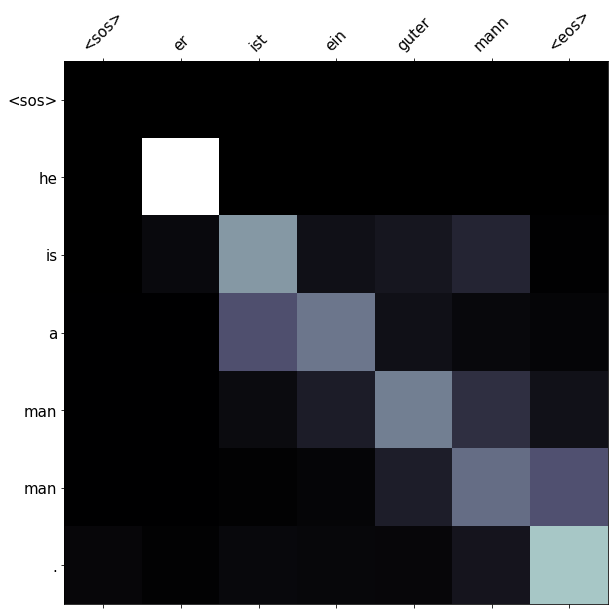

In [44]:
translation, attention = german2english(input_sentence, SRC.vocab, model, device)

print(f'predicted trg = {" ".join(translation)}')

display_attention(input_sentence, translation, attention)

In [16]:
batch_size= 1
embedding_dim = 7
sent_len = 5
k_size = 3

In [19]:
m = nn.Conv1d(in_channels=embedding_dim, out_channels=10, kernel_size=k_size, padding=(k_size - 1) // 2)

In [20]:
inp = torch.randn(batch_size, embedding_dim, sent_len)
output = m(inp)

In [22]:
output.shape

torch.Size([1, 10, 5])

In [26]:
k = torch.ones((1, 10))
k

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [37]:
(k != 0.7721).permute(1, 0)

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.uint8)

In [33]:
attention = torch.rand((1, 10))
print(attention.shape)
attention

torch.Size([1, 10])


tensor([[0.7721, 0.8888, 0.9195, 0.6260, 0.4997, 0.6248, 0.9466, 0.9943, 0.1042,
         0.7080]])

In [38]:
attention.masked_fill(k == 0, -1e10)

tensor([[0.7721, 0.8888, 0.9195, 0.6260, 0.4997, 0.6248, 0.9466, 0.9943, 0.1042,
         0.7080]])

In [36]:
(k == 1)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.uint8)